In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
data = pd.read_csv('/Users/Kirill/lerning/Lectiont_DS/Decision tree classifier/pulsar_data_train.csv')

In [3]:
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [4]:
data.isnull().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [5]:
for col in data.columns:
    data[col].fillna(data[col].median(), inplace = True)

In [6]:
X = data.drop('target_class', axis = 1)
y = data['target_class']

In [7]:
from sklearn.preprocessing import StandardScaler
col = X.columns
scaler = StandardScaler().fit_transform(X)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaler, y, random_state=0, test_size = 0.25)

In [9]:
import torch.nn.functional as F

In [10]:
device = torch.device('cuda')

In [12]:
%%time

class MyFirstNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cl1 = nn.Linear(8, 32)
        self.cl2 = nn.Linear(32, 16)
        self.cl3 = nn.Linear(16, 8)
        self.cl4 = nn.Linear(8, 1)
        
        
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.cl3(x))
        x = F.sigmoid(self.cl4(x))
        return x
    
model = MyFirstNN()
model = model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

X_tr = torch.tensor(X_train, dtype = torch.float32)
X_tr = X_tr.to(device)
X_te = torch.tensor(X_test, dtype = torch.float32)
X_te = X_te.to(device)
y_tr = torch.tensor(np.array(y_train), dtype = torch.float32)
y_tr = y_tr.to(device)
y_te = torch.tensor(np.array(y_test), dtype = torch.float32)
y_te = y_te.to(device)

train_loss = []
test_loss = []
for i in tqdm(range(300)):
    pred_train = model(X_tr)
    loss = F.binary_cross_entropy_with_logits(pred_train, y_tr.reshape(-1,1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    if i % 5 == 0:
        pred_test = model(X_te)
        loss = F.binary_cross_entropy_with_logits(pred_test, y_te.reshape(-1,1))
        test_loss.append(loss.item())

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 472.20it/s]

CPU times: total: 1.34 s
Wall time: 769 ms


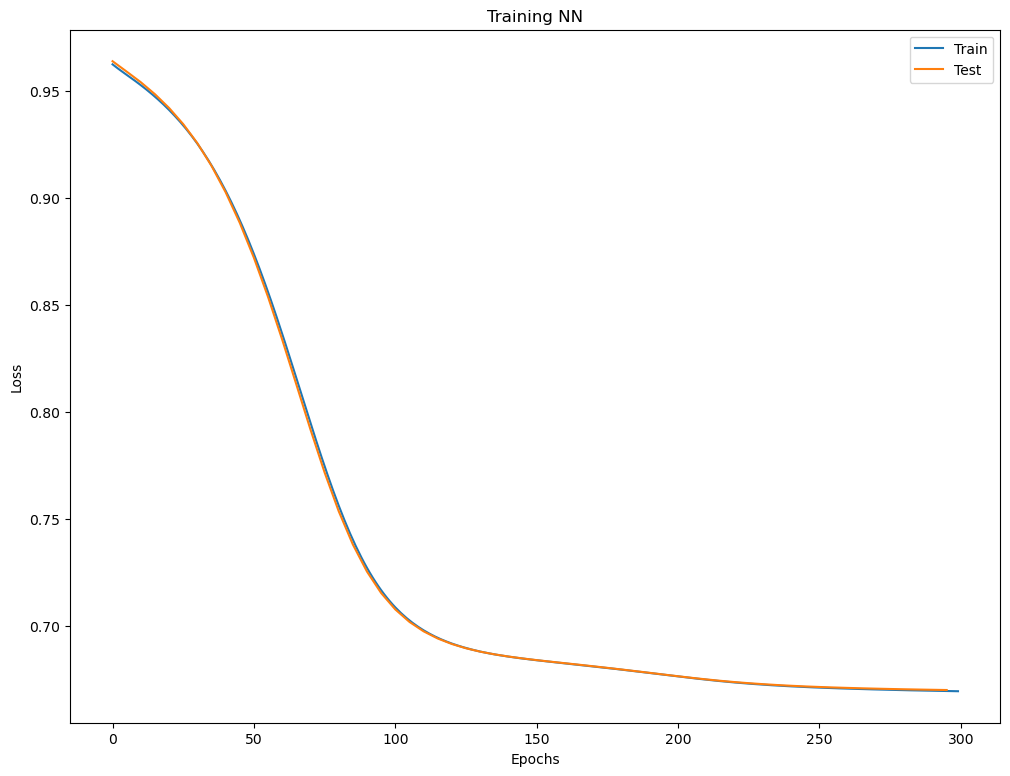

In [27]:
plt.figure(figsize = (12,9))
plt.plot(range(300), np.array(train_loss), label = 'Train')
plt.plot(range(300)[::5], np.array(test_loss), label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training NN')
plt.legend()
plt.show()

In [124]:
sum(torch.round(torch.sigmoid(pred_train))==1)

tensor([761], device='cuda:0')

In [28]:
F.softmax(pred_train, dim=0) # Если применить на последнем слое софтмакс, что было бы логично
                             # получаются сплошные нули, и больше ничего, если указать дим1(что не правильно, но как
                             # вариант тоже проверил) все ответы становятся единицами, подсмотрел в интернете такой вариант
                             # решения, как приминение сигмоиды(ее использовали на ответах, но я ее включил в последний
                             # слой) и округлить с помощью раунд. Как представлено выше.

tensor([[9.4673e-05],
        [9.4968e-05],
        [9.4743e-05],
        ...,
        [1.1999e-04],
        [9.4680e-05],
        [9.4881e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [31]:
torch.unique(torch.round(pred_train))

tensor([0., 1.], device='cuda:0', grad_fn=<Unique2Backward0>)

In [33]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(torch.round(pred_train).to('cpu').detach().numpy(), y_tr.to('cpu').detach().numpy())

0.9739250744997872

In [35]:
print(classification_report(torch.round(pred_train).to('cpu').detach().numpy(), y_tr.to('cpu').detach().numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      8694
         1.0       0.76      0.95      0.84       702

    accuracy                           0.97      9396
   macro avg       0.88      0.96      0.92      9396
weighted avg       0.98      0.97      0.98      9396



In [36]:
print(classification_report(torch.round(pred_test).to('cpu').detach().numpy(), y_te.to('cpu').detach().numpy()))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2905
         1.0       0.78      0.96      0.86       227

    accuracy                           0.98      3132
   macro avg       0.89      0.97      0.92      3132
weighted avg       0.98      0.98      0.98      3132



#### Вывод

_В целом, модель показывает довольно не плохие результаты, как при обучении, так и при тесте._

_Модель не переобучилась._

_Вроде бы даже корректно работает)_